# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import os
import json
import datetime
import contractions
import pickle
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, RFE
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/sentiment_env/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/sentiment_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
        
    def basic_processing(self, data):
        data = data.drop(['date', 'timestamp'], axis=1)
        print(f'\nNumber of duplicate entry of unlabelled data: {data.tweet.duplicated().sum()}')
        # Remove duplicates
        data = data[~data.tweet.duplicated()]
        print(f'Duplicate entry removed: {data.tweet.duplicated().sum()}')
        # We will remove the usernames and RT(retweet) in the tweet column
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
        return data

    def train_data(self):
        data = pd.read_csv(os.path.join(config.DATAPATH, 'train.csv'))
        # Remove all records with no label
        data = data[data.label != '']
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        return data

if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    stored_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(stored_data)
    unlabelled_data = t.basic_processing(stored_data)
    labelled_data = t.train_data()

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

In [3]:
print(unlabelled_data.shape)
unlabelled_data.info()
unlabelled_data.head(10)

(3112, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 0 to 4022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3112 non-null   object
 1   tweet   3112 non-null   object
dtypes: object(2)
memory usage: 72.9+ KB


,id,tweet
0,1547971096388915211,Truth and Reconciliation Week - sign up VSB ed...
1,1547973807876345856,Uh oh she’s writing songs #inthefeels 🔪
2,1548039239316541449,#Killing white #supremacists by Bill O'Really....
3,1548287847995609092,hiya. cats are feeling fuming and accomplished...
4,1548297674062868480,If home ownership requires generational wealth...
5,1548327299304783875,RT @RobertR41182121: THIS IS SATANIC #ZIONAZI ...
6,1548582052240539648,@Inspiredlawyer #BabyFactories: sick ultimate ...
7,1548640420418273282,#Platform class kotlin.Unit #requires explicit...
8,1548681295189901317,The Let Them Eat Cake Club #Supremacists #Liar...
10,1549225465658982401,Kinda sad my bachelorette party is over 🥺#miss...


In [4]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=2000, ngram_range=(1, 2))
lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

print(labelled_data.shape)
labelled_data.info()
labelled_data.head(10)

(31962, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


# Target Exploration (label)

In [5]:
labelled_data.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

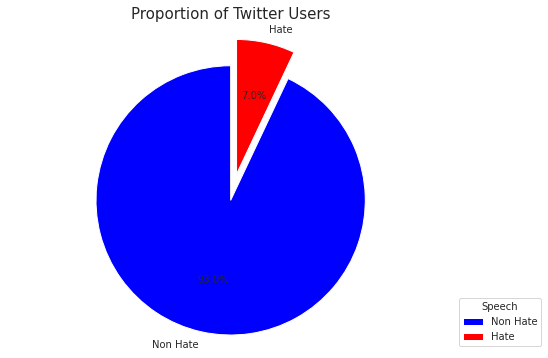

In [6]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 7.0% of twitter users might Hate. So the baseline model could be to predict that 7.0% of the users will Hate. Given 7.0% is a small number, we need to ensure that the chosen model does predict with great accuracy this 7.0% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [7]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')


The longest for labelled tweet is: 196
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 297
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

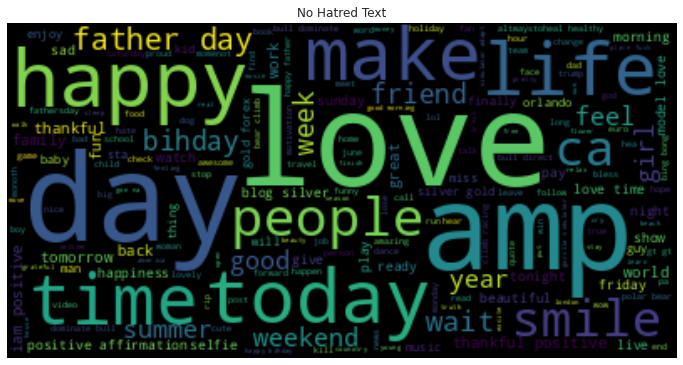

In [8]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('No Hatred Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

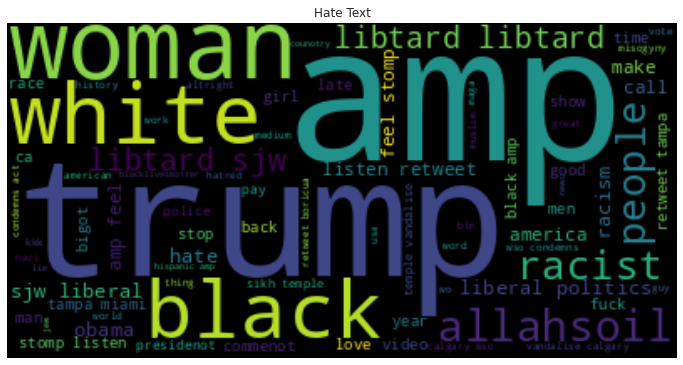

In [9]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [10]:
def transform(data, column):
    # We will encode text data using TF-IDF
    tfidf_feats = tfVectorizer.fit(data[column])
    tfidf_feats = tfidf_feats.transform(data[column]).toarray()
    tfidf = pd.DataFrame(tfidf_feats, columns=tfVectorizer.get_feature_names())
    return tfidf

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

data_tfidf = transform(data_cleaned, 'cleaned_text')
unlabelled_tfidf = transform(unlabelled_cleaned, 'cleaned_text')


# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [11]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['tweet'], axis=1)
    return data




data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 4min 42s, sys: 5.52 s, total: 4min 48s
Wall time: 4min 53s


# Check for Missing Values

In [12]:
print(data_cleaned.isnull().sum().sort_values(ascending=False))

aap                0
pink               0
poem               0
podcast            0
pm                 0
                  ..
followme           0
follower           0
follow followme    0
follow             0
uppercase_count    0
Length: 2020, dtype: int64


In [13]:
print(unlabelled_cleaned.isnull().sum().sort_values(ascending=False))

ab                 0
producer           0
protester          0
protest            0
protect            0
                  ..
freedom            0
free inoternet     0
free               0
freak              0
uppercase_count    0
Length: 2019, dtype: int64


In [14]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['id', 'label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned, target_labelled_data, test_size=0.2, random_state=43)
print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

Train Size: 0.80%
Test Size: 0.20%
(25569, 2018) (25569,) (6393, 2018) (6393,) (2442, 2019)


# Model Building & Evaluation

### Get the best Model to perform Pseudo-Labelling on the unlabelled_data

In [15]:
def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'], yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    nb_clf = MultinomialNB(alpha=a)
    nb_clf.fit(X_train, y_train)
    pred = nb_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{a}->{auc:.4f}")

0.0001->0.9152
0.001->0.9191
0.01->0.9241
0.1->0.9277
1->0.9147
10->0.6410


ROC AUC Naive Bayes Score: 0.9277


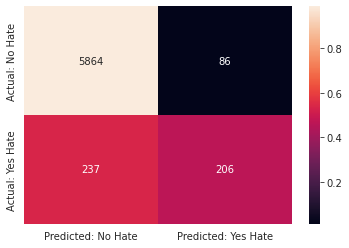

In [16]:
nb_clf = MultinomialNB(alpha=0.1)
nb_clf.fit(X_train, y_train)
pred = nb_clf.predict_proba(X_test)[:, 1]
y_pred = nb_clf.predict(X_test)
print(f"ROC AUC Naive Bayes Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

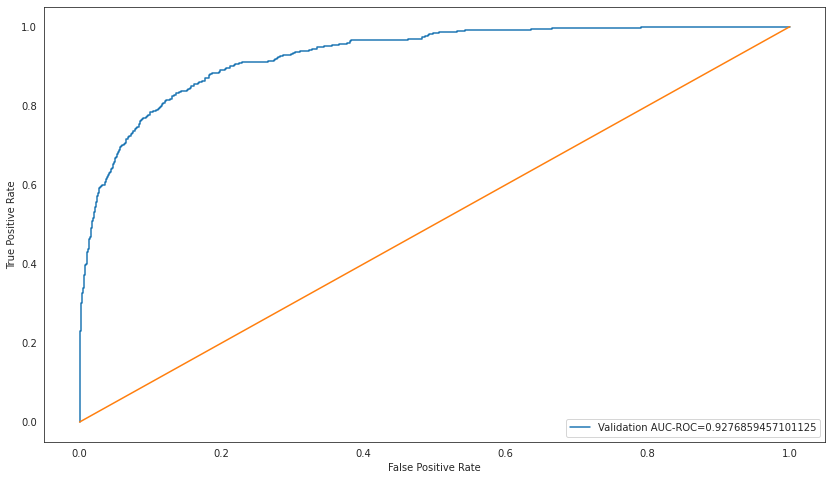

In [18]:
plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

In [19]:
for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    logReg = LogisticRegression(solver='liblinear', C=c)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

0.0001->0.4843
0.001->0.6344
0.01->0.7375
0.1->0.8976
1->0.9300
10->0.9305


In [20]:
for m in [0.1, 1, 10]:
    print(f"Inverse of regularization strength {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        logReg = LogisticRegression(solver='liblinear', C=m, tol=tol)
        logReg.fit(X_train, y_train)
        pred = logReg.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength 0.1
1e-05->0.8977
0.0001->0.8976
0.001->0.8981
0.01->0.6372
0.1->0.4516
1->0.4497
10->0.4497

Inverse of regularization strength 1
1e-05->0.9303
0.0001->0.9300
0.001->0.9283
0.01->0.6370
0.1->0.4516
1->0.4497
10->0.4497

Inverse of regularization strength 10
1e-05->0.9308
0.0001->0.9305
0.001->0.9312
0.01->0.6370
0.1->0.4516
1->0.4497
10->0.4497



In [22]:
for maxIt in [1, 5, 10, 15, 20]:
    logReg = LogisticRegression(solver='liblinear', C=10, tol=0.001, max_iter=maxIt)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{maxIt}->{auc:.4f}")

1->0.4497
5->0.4775
10->0.6594
15->0.7477
20->0.8233


In [24]:
for mClass in ["auto", "ovr"]:
    logReg = LogisticRegression(solver='liblinear', C=10, tol=0.001, multi_class=mClass)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9312
ovr->0.9312


ROC AUC Logistic Regression Score: 0.9312


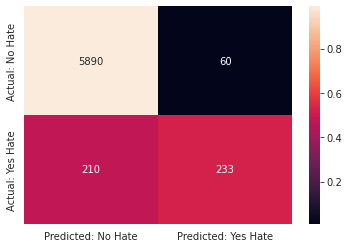

In [25]:
logReg = LogisticRegression(solver='liblinear',
                            C=10, tol=0.001, 
                            multi_class='auto')

logReg.fit(X_train, y_train)
pred = logReg.predict_proba(X_test)[:, 1]
y_pred = logReg.predict(X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

ROC AUC Naive Bayes Score: 0.9312


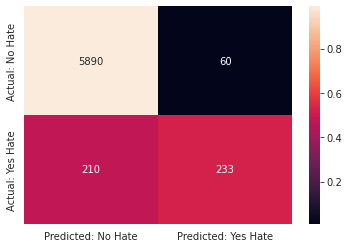

ROC AUC Naive Bayes Score: 0.9294


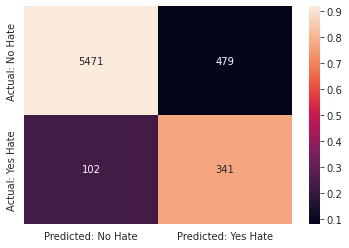

ROC AUC Naive Bayes Score: 0.9339


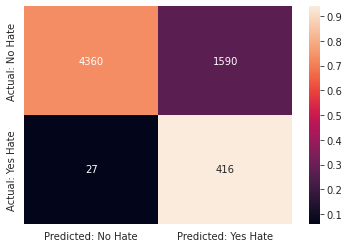

In [30]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    logReg = LogisticRegression(solver='liblinear',
                            C=10, tol=0.001, 
                            multi_class='auto',
                            class_weight=weight)
                            
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    y_pred = logReg.predict(X_test)
    print(f"ROC AUC Naive Bayes Score: {roc_auc_score(y_test, pred):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()